In [423]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import seaborn as sns

In [424]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [425]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
metrics_dir = data_dir / 'model_data'

# Read data

## 5 PPI DL

In [426]:
# Read dataframe
path = metrics_dir / '5PPI_GNN.csv'

df = pd.read_csv(path)
df = df.iloc[:-1]

# Rename columns
df['Model'] = df.Name.str.split('_').str[:-4].str.join('_')
df = df[['Model', 'graph_pooling', 'val_acc', 'val_auc', 'val_f1']]
df.columns = ['Model', 'Pooling', 'Accuracy', 'AUC', 'F1']
df.Model = df.Model.str.replace('MLP', 'MIL')

df_dl = df.copy()

# Groupby
df_group = df.groupby(['Model', 'Pooling']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [427]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

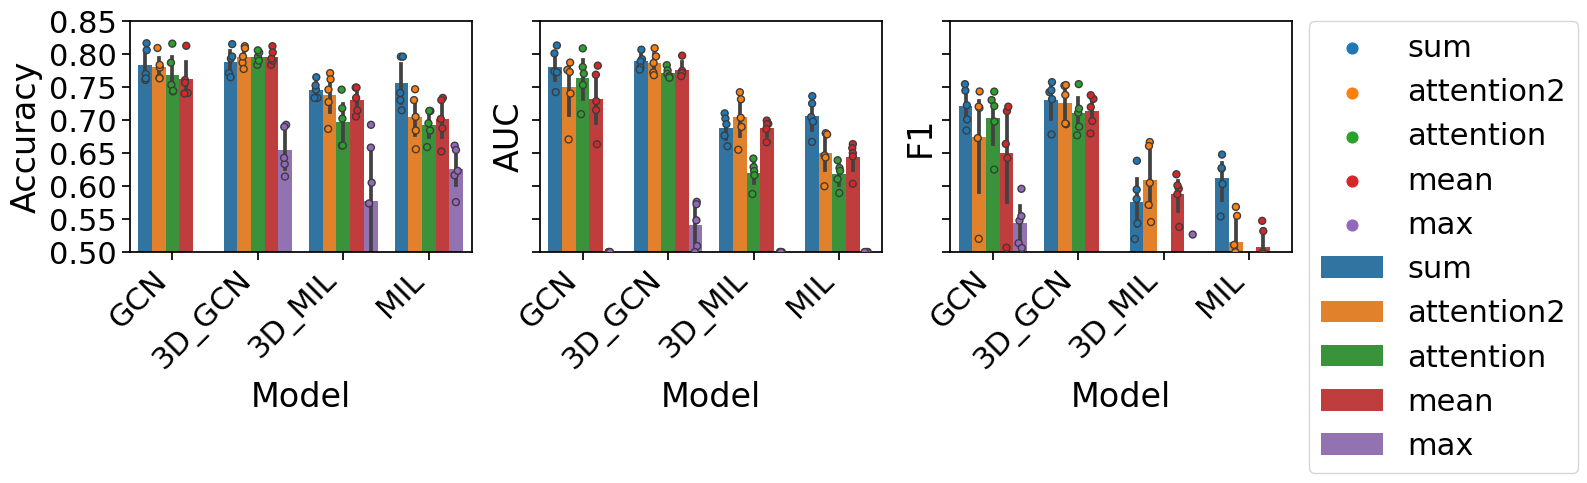

In [428]:
x = 'Model'
hue = 'Pooling'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3977784750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['2D'] = df_subset['Model'].str.split('_').str[0]
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3977784750.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['2D'] = df_subset['2D'].map(lambda x: {'GCN':'2D'}.get(x,x))


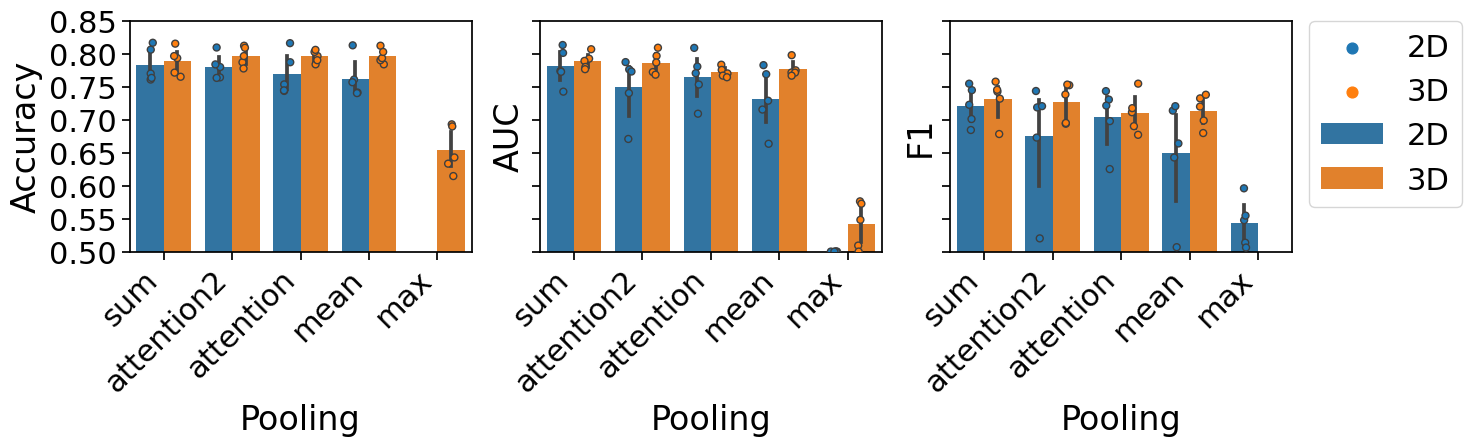

In [429]:
x = 'Pooling'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']

df_subset = df[df.Model.str.contains('GCN')]
df_subset['2D'] = df_subset['Model'].str.split('_').str[0]
df_subset['2D'] = df_subset['2D'].map(lambda x: {'GCN':'2D'}.get(x,x))

df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

In [430]:
df_subset = df.copy()
df_subset['2D'] = df_subset['Model'].str.split('_').str[0]
df_subset['2D'] = df_subset['2D'].map(lambda x: {'GCN':'2D', 'MIL': '2D'}.get(x,x))
df_subset['Model'] = df_subset['Model'].str.split('_').str[-1]

g = df_subset.groupby(['Model', 'Pooling', '2D'], as_index=False).mean()
g = g.groupby(['Model'], as_index=False).apply(lambda x: x.loc[x['AUC'].idxmax()])

dfs = []
for row in g.itertuples():
    df_sub = df_subset[(df_subset.Model == row.Model) & (df_subset.Pooling == row.Pooling)]
    dfs.append(df_sub)
df_max = pd.concat(dfs)

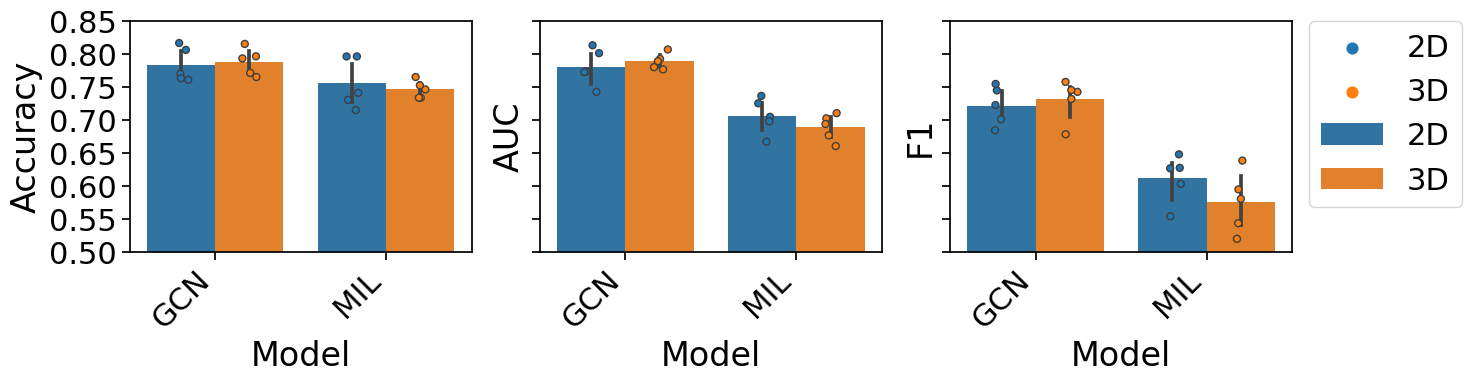

In [431]:
x = 'Model'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']

df_melt =  df_max.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

## 5 PPI ML

In [432]:
## MLP
# Read dataframe
path = metrics_dir / '5PPI_MLP.csv'

df = pd.read_csv(path)

# Rename columns
df['Model'] = df.Name.str.split('_').str[:-4].str.join('_')
df['Type'] = df.Name.str.split('_').str[-2]

df = df[['Model', 'Type','val_acc', 'val_auc', 'val_f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto':'Subcellular', 'cell':'Cellular'}.get(x,x))

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

df_mlp_2D = df[~df.Model.str.contains('3D')]
df_mlp_3D = df[df.Model.str.contains('3D')]
df_mlp_3D['Model'] = 'MLP'

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\973933425.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mlp_3D['Model'] = 'MLP'


In [433]:
# Read dataframe
path = metrics_dir / '5PPI_ML.csv'

df = pd.read_csv(path)

# # Rename columns
df['Model'] = df.Name.str.split('_').str[0]
df['Type'] = df.Name.str.split('_').str[1:-1].str.join('_')

df = df[['Model', 'Type', 'accuracy', 'auc', 'f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto_nuclei':'Subcellular', 'cell':'Cellular'}.get(x,x))
df = pd.concat([df, df_mlp_2D])

df_2D = df.copy()
df_2D['2D'] = '2D'

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [434]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

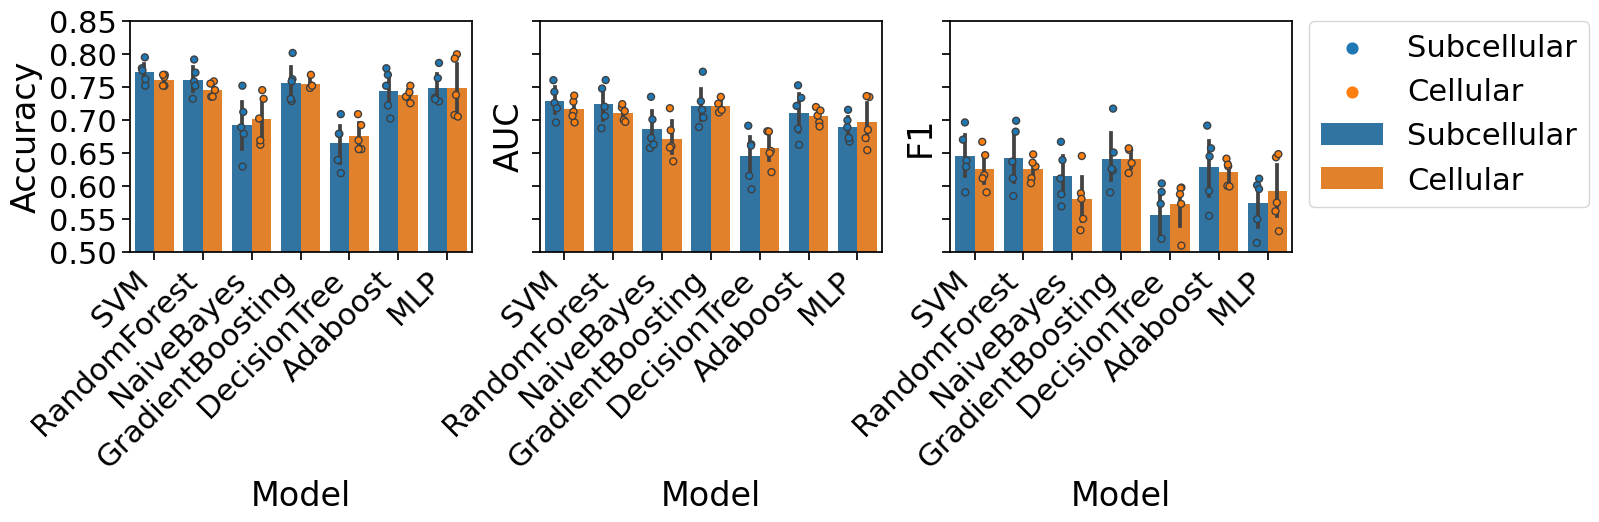

In [435]:
x = 'Model'
hue = 'Type'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

In [436]:
# Read dataframe
path = metrics_dir / '5PPI_ML_3D.csv'

df = pd.read_csv(path)

# # Rename columns
df['Model'] = df.Name.str.split('_').str[0]
df['Type'] = df.Name.str.split('_').str[1:-1].str.join('_')

df = df[['Model', 'Type', 'accuracy', 'auc', 'f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto_nuclei':'Subcellular', 'cell':'Cellular'}.get(x,x))
df = pd.concat([df, df_mlp_3D])

df_3D = df.copy()
df_3D['2D'] = '3D'

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [437]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

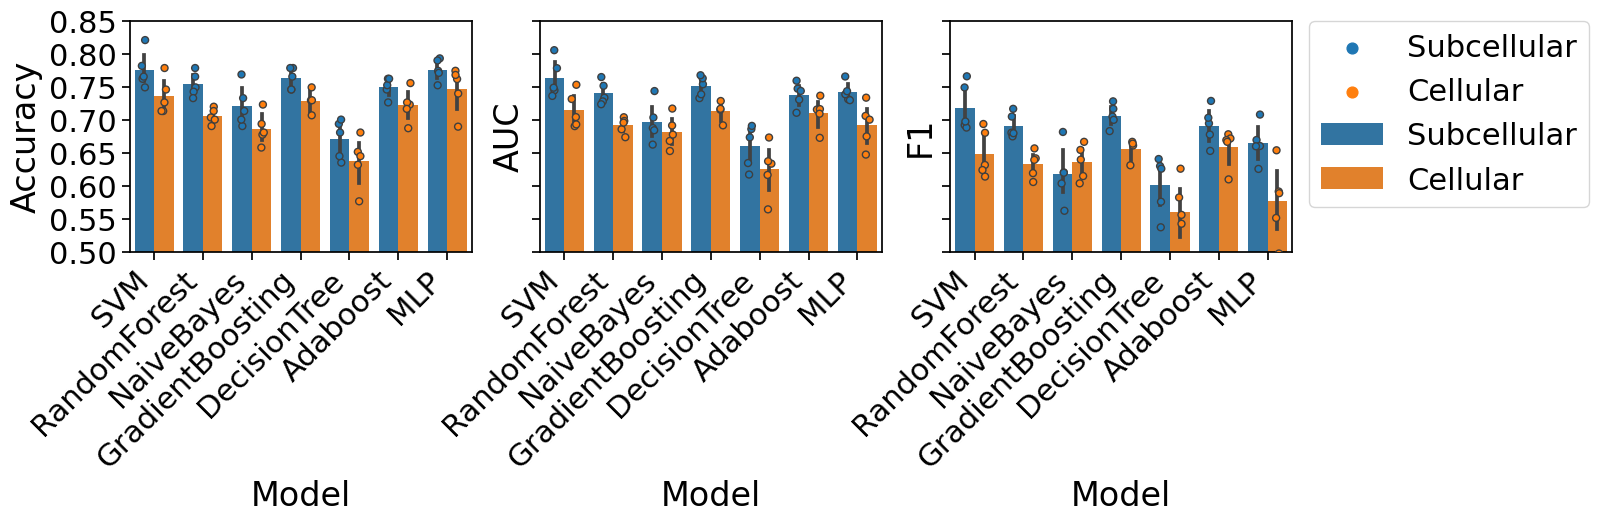

In [438]:
x = 'Model'
hue = 'Type'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

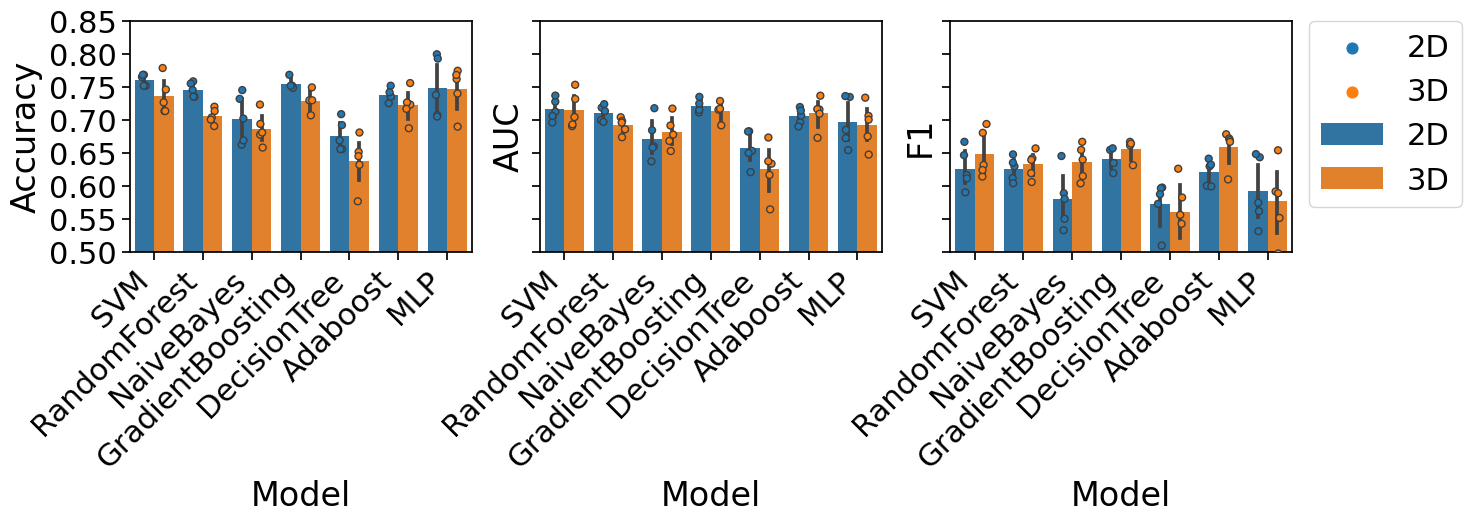

In [439]:
# 2D vs 3D comparison cell
df = pd.concat([df_2D, df_3D])

df_subset = df[df.Type == 'Cellular']
x = 'Model'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

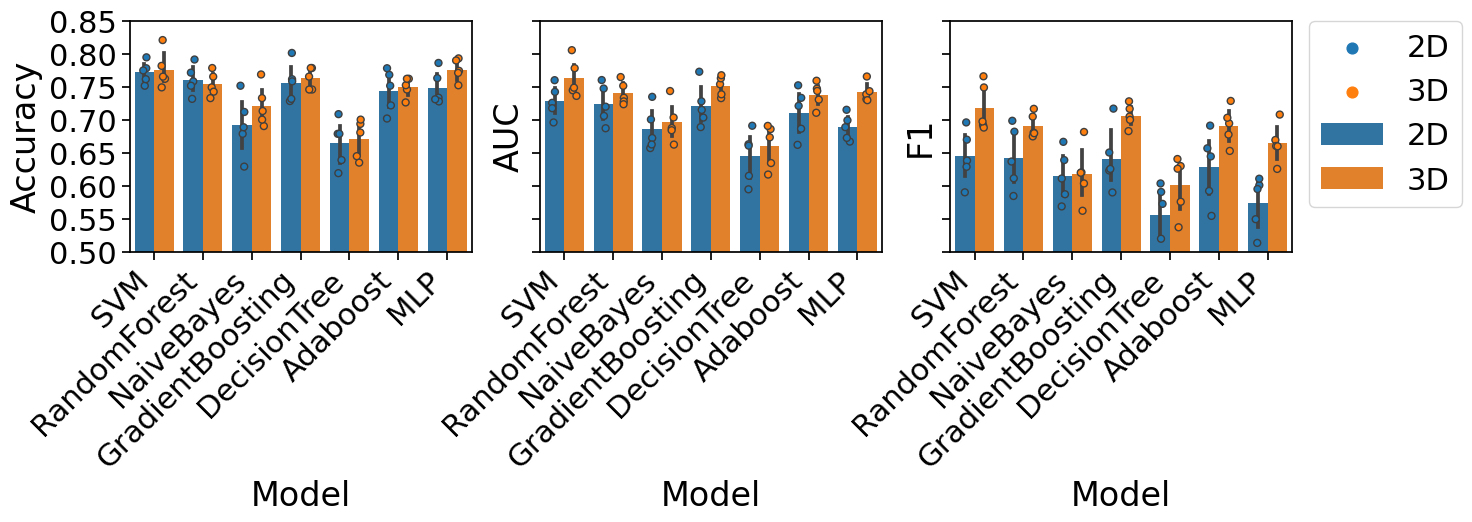

In [440]:
# 2D vs 3D comparison subcellular
df_subset = df[df.Type == 'Subcellular']
x = 'Model'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

## Compare

In [441]:
# Drop minimum per group
g = df_dl.groupby(['Model'])['AUC'].transform('max')
df_dl_max = df_dl.loc[(df_dl['AUC'] == g)]
df_dl_max['2D'] = df_dl_max['Model'].str.contains('3D')
df_dl_max['2D'] = df_dl_max['2D'].apply(lambda x: {False:'2D', True:'3D'}.get(x,x))
df_dl_max['Model'] = df_dl_max['Model'].str.split('_').str[-1]
df_dl_max.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1', '2D']

# Drop minimum per group
g = df.groupby(['Type', '2D'])['AUC'].transform('max')
df_ml_max = df.loc[(df['AUC'] == g)]

# MLP
df_mlp = df[df.Model == 'MLP']
df_mlp = df_mlp.groupby(['Model', 'Type', '2D']).mean().reset_index()

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dl_max['2D'] = df_dl_max['Model'].str.contains('3D')
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dl_max['2D'] = df_dl_max['2D'].apply(lambda x: {False:'2D', True:'3D'}.get(x,x))
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [442]:
df_max = pd.concat([df_dl_max, df_ml_max, df_mlp])
df_max = df_max.sort_values(by=['2D', 'Type'])
df_max.to_clipboard()

## 9 PPI DL

In [443]:
# Read dataframe
path = metrics_dir / '9PPI_DL.csv'

df = pd.read_csv(path)
df = df[~df.Name.str.contains('cell')]
df = df[~df.Name.str.contains('cyto')]

# Rename columns
df['Model'] = df.Name.str.split('_').str[:-4].str.join('_')
df = df[['Model', 'graph_pooling', 'val_acc', 'val_auc', 'val_f1']]
df.columns = ['Model', 'Pooling', 'Accuracy', 'AUC', 'F1']

# Drop minimum per group
g = df.groupby(['Model', 'Pooling'])['AUC'].transform('min')
df = df.loc[(df['AUC'] != g)]
df.Model = df.Model.str.replace('MLP', 'MIL')

df_dl = df.copy()

# Groupby
df_group = df.groupby(['Model', 'Pooling']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [444]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

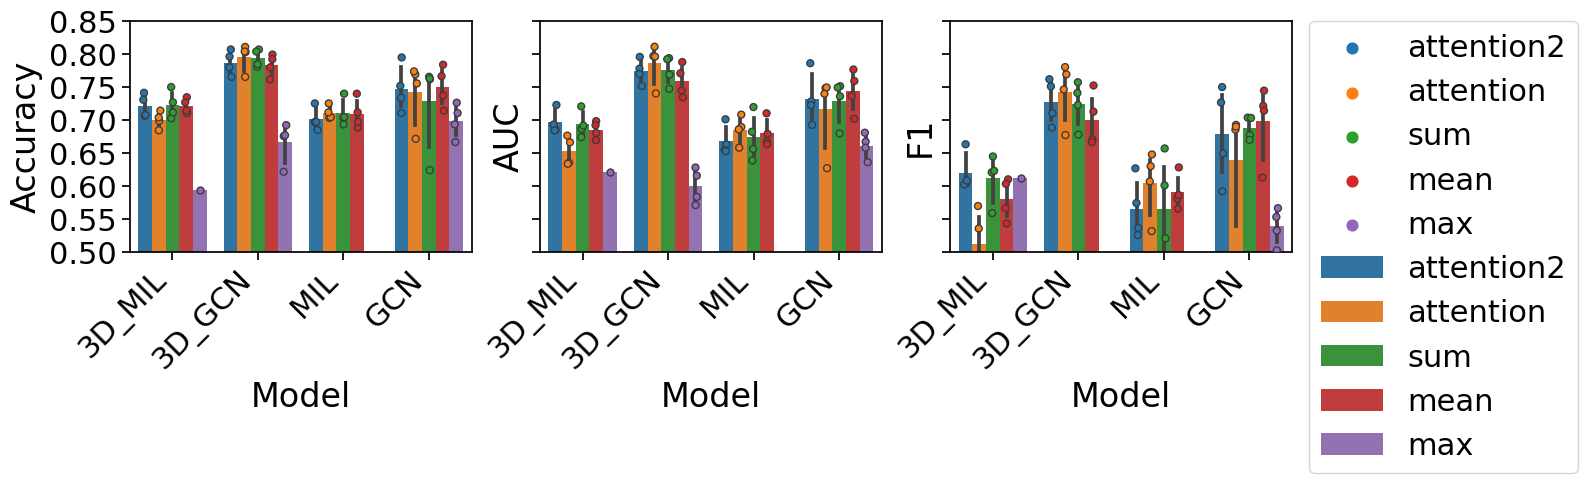

In [445]:
x = 'Model'
hue = 'Pooling'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\1763622578.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['2D'] = df_subset['Model'].str.split('_').str[0]
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\1763622578.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['2D'] = df_subset['2D'].map(lambda x: {'GCN':'2D'}.get(x,x))


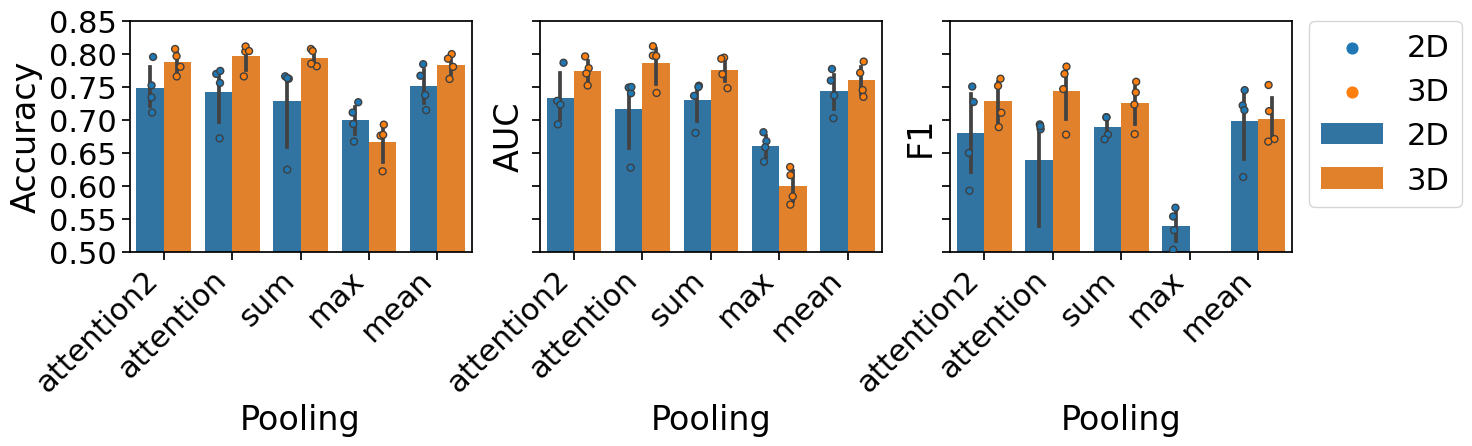

In [446]:
x = 'Pooling'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']

df_subset = df[df.Model.str.contains('GCN')]
df_subset['2D'] = df_subset['Model'].str.split('_').str[0]
df_subset['2D'] = df_subset['2D'].map(lambda x: {'GCN':'2D'}.get(x,x))

df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                    hue_order=['2D', '3D'],
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue,
                       hue_order=['2D', '3D'],
                      dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

## 9 PPI ML

In [447]:
## MLP
# Read dataframe
path = metrics_dir / '9PPI_DL.csv'

df = pd.read_csv(path)

# Rename columns
df['Model'] = df.Name.str.split('_').str[:-4].str.join('_')
df['Type'] = df.Name.str.split('_').str[-2]

df = df[['Model', 'Type','val_acc', 'val_auc', 'val_f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto':'Subcellular', 'cell':'Cellular'}.get(x,x))
df = df[~(df.Type == 'onehot')]

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

df_mlp_2D = df[~df.Model.str.contains('3D')]
df_mlp_3D = df[df.Model.str.contains('3D')]
df_mlp_3D['Model'] = 'MLP'

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\4014339869.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mlp_3D['Model'] = 'MLP'


In [448]:
# Read dataframe
path = metrics_dir / '9PPI_ML.csv'

df = pd.read_csv(path)

# Rename columns
df['Model'] = df.Name.str.split('_').str[0]
df['Type'] = df.Name.str.split('_').str[1:-1].str.join('_')

df = df[['Model', 'Type', 'accuracy', 'auc', 'f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto_nuclei':'Subcellular', 'cell':'Cellular'}.get(x,x))
df = pd.concat([df, df_mlp_2D])

df_2D = df.copy()
df_2D['2D'] = '2D'

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [449]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

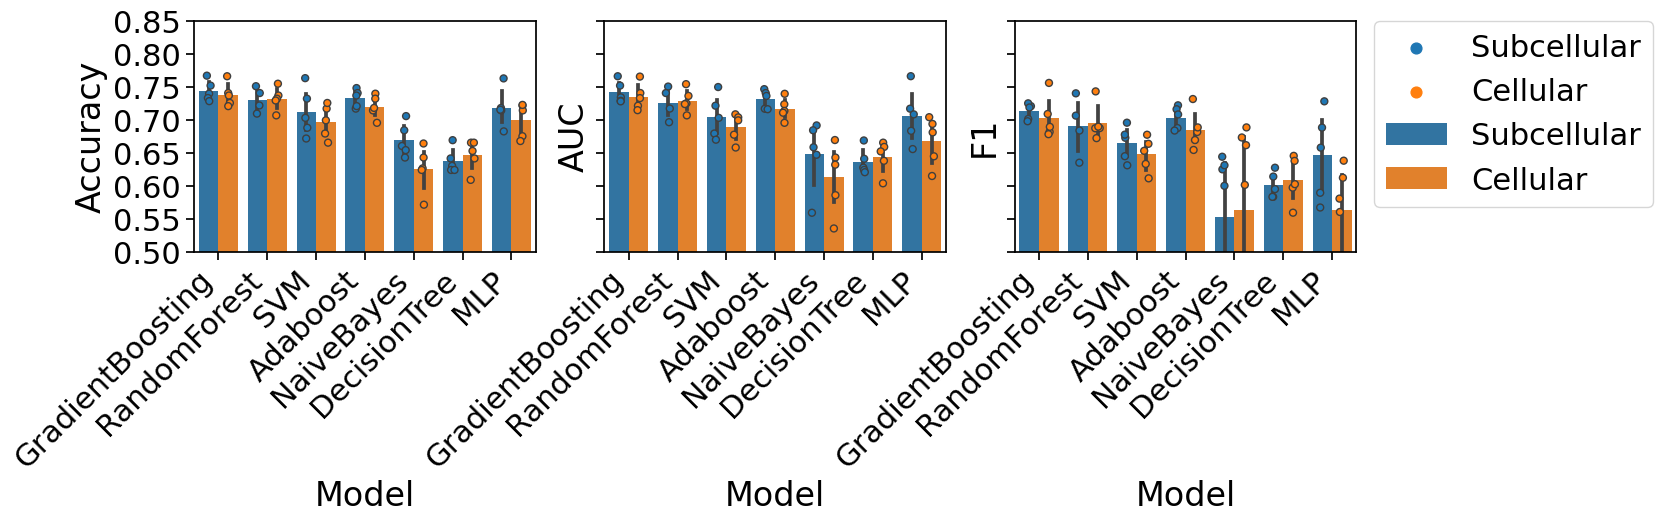

In [450]:
x = 'Model'
hue = 'Type'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

In [451]:
# Read dataframe
path = metrics_dir / '9PPI_ML_3D.csv'

df = pd.read_csv(path)

# # Rename columns
df['Model'] = df.Name.str.split('_').str[0]
df['Type'] = df.Name.str.split('_').str[1:-1].str.join('_')

df = df[['Model', 'Type', 'accuracy', 'auc', 'f1']]
df.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1']
df['Type'] = df['Type'].apply(lambda x: {'cyto_nuclei':'Subcellular', 'cell':'Cellular'}.get(x,x))
df = pd.concat([df, df_mlp_2D])

df_3D = df.copy()
df_3D['2D'] = '3D'

# Groupby
df_group = df.groupby(['Model', 'Type']).agg(['mean', 'std'])  
df_group = df_group.round(3)

In [452]:
dfs = []
metrics = ['Accuracy', 'AUC', 'F1']
for m in metrics:
    dfs.append(df_group[(m, 'mean')].astype('str') 
               + ' +- ' 
               + df_group[(m, 'std')].astype('str'))

df_final = pd.concat(dfs, axis=1)
df_final.columns = metrics
df_final.to_clipboard()

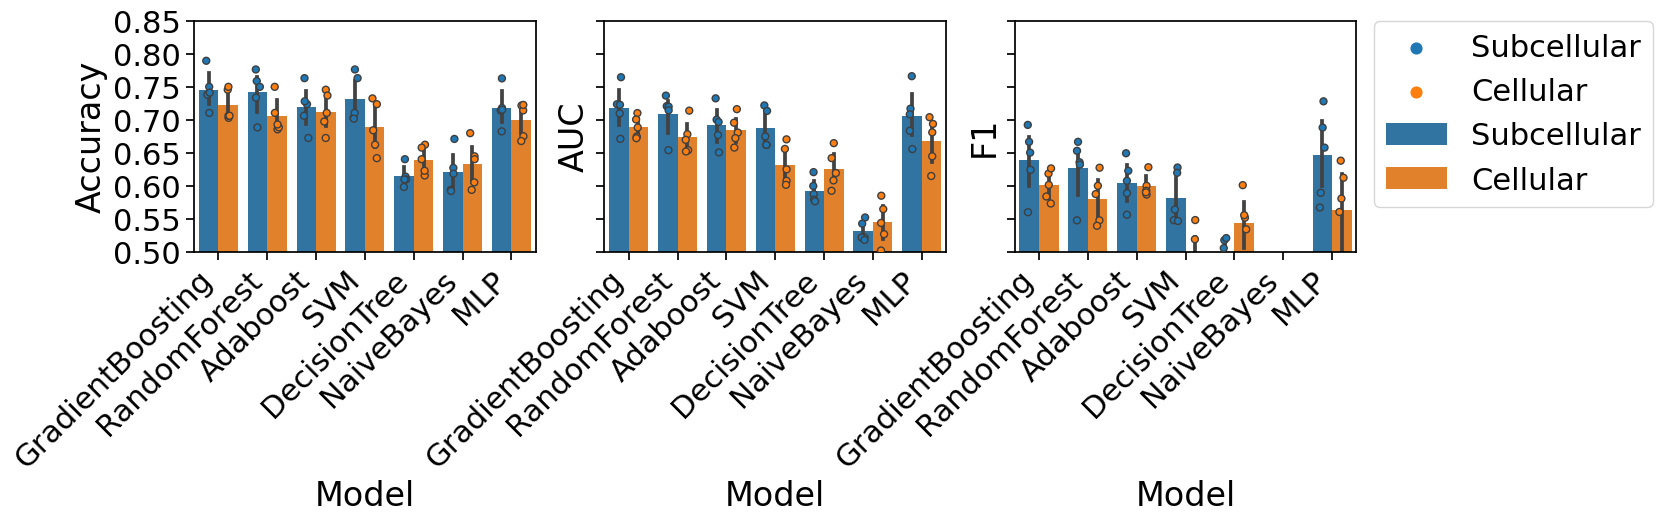

In [453]:
x = 'Model'
hue = 'Type'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

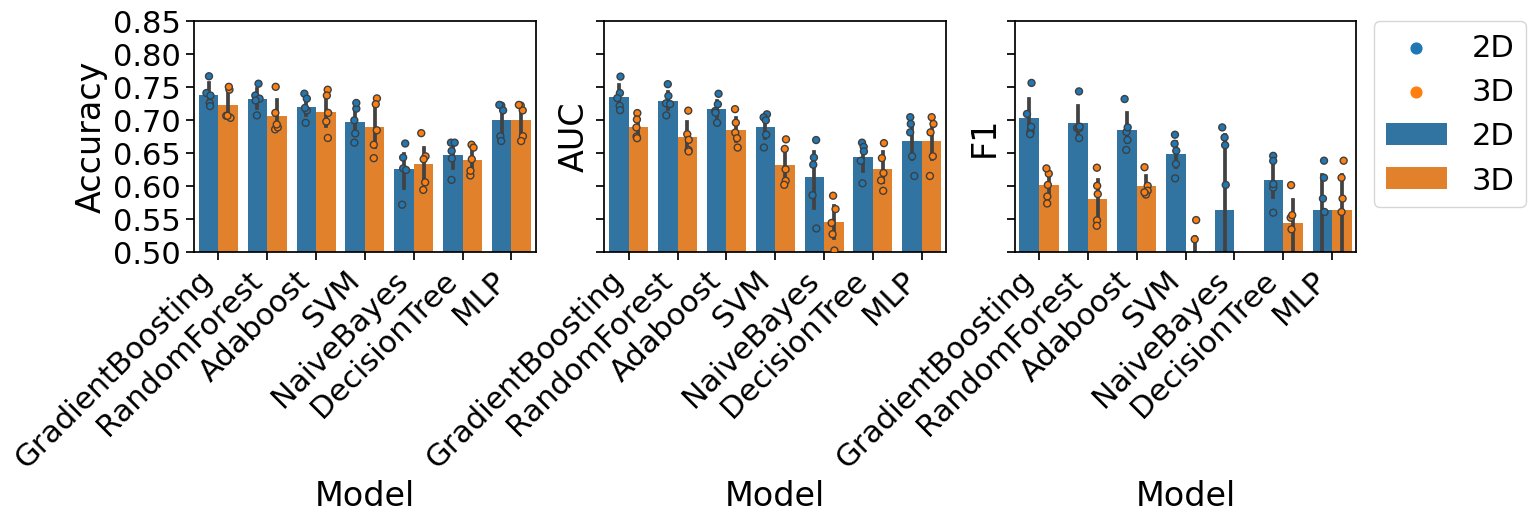

In [454]:
# 2D vs 3D comparison cell
df = pd.concat([df_2D, df_3D])


df_subset = df[df.Type == 'Cellular']
x = 'Model'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

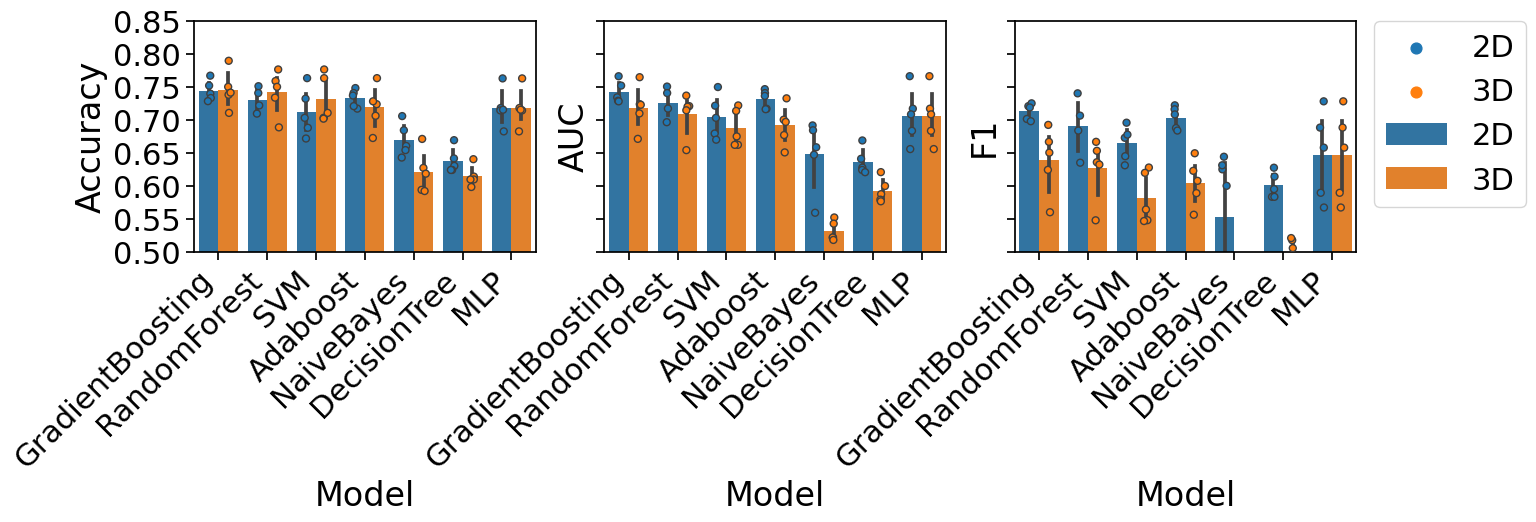

In [455]:
# 2D vs 3D comparison subcellular
df_subset = df[df.Type == 'Subcellular']
x = 'Model'
hue = '2D'
metrics = ['Accuracy', 'AUC', 'F1']
df_melt =  df_subset.melt(id_vars=[x, hue], value_vars=['Accuracy', 'AUC', 'F1'], var_name='Metric', value_name='Score')

with sns.plotting_context('notebook', font_scale=2):
    fig, axs = plt.subplots(1,3, figsize=(15,3), sharey=True)
    for i, metric in enumerate(metrics):
        ax=axs[i]
        sns.barplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, 
                   ax=ax)
        ax.set(ylim=(0.5, 0.85))
        sns.stripplot(data=df_melt[df_melt.Metric == metric], x=x, y='Score', hue=hue, dodge=True, linewidth=1,ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        if i ==2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        else:
            ax.legend([],[], frameon=False)
        

## Compare

In [456]:
# Drop minimum per group
g = df_dl.groupby(['Model'])['AUC'].transform('max')
df_dl_max = df_dl.loc[(df_dl['AUC'] == g)]
df_dl_max['2D'] = df_dl_max['Model'].str.contains('3D')
df_dl_max['2D'] = df_dl_max['2D'].apply(lambda x: {False:'2D', True:'3D'}.get(x,x))
df_dl_max['Model'] = df_dl_max['Model'].str.split('_').str[-1]
df_dl_max.columns = ['Model', 'Type', 'Accuracy', 'AUC', 'F1', '2D']

# Drop minimum per group
g = df.groupby(['Type', '2D'])['AUC'].transform('max')
df_ml_max = df.loc[(df['AUC'] == g)]

# MLP
df_mlp = df[df.Model == 'MLP']
df_mlp = df_mlp.groupby(['Model', 'Type', '2D']).mean().reset_index()

C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dl_max['2D'] = df_dl_max['Model'].str.contains('3D')
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dl_max['2D'] = df_dl_max['2D'].apply(lambda x: {False:'2D', True:'3D'}.get(x,x))
C:\Users\thu71\AppData\Local\Temp\ipykernel_55136\3886945656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [457]:
df_max = pd.concat([df_dl_max, df_ml_max, df_mlp])
df_max = df_max.sort_values(by=['2D', 'Type'])
df_max.to_clipboard()